In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helpers.io_utils import load_lemma, create_results_dir
from helpers.collocations import correct_text, extract_collocations_bigram, collocations_df, words_df
from helpers.vectorize import vectorize_colocation_df, get_mi_score
from helpers.io_utils import save_collocations_df, save_words_df, save_corpus_df
from helpers.GAM import gam_prediction

folder_path = Path("files/Reference")
phrase = "zmian klimat"
corpus_path = Path("combo")

In [2]:
def filter_important(text, mi):
    words = text.split()
    return any([word in mi['word'].values for word in words])

def get_reference_values(folder_path, phrase, corpus_path):
    words = phrase.split()

    df_corpus = load_lemma(corpus_path)
    df_corpus = correct_text(df_corpus, correction_pattern=rf'(?<!\s)({words[0]}[^ ]* {words[1]}[^ ]*)')    
    df_corpus = extract_collocations_bigram(df_corpus, bigram_pattern=phrase)
    df_colocates = collocations_df(df_corpus)
    df_words = words_df(df_colocates)
    df_mi = get_mi_score(df_words, df_corpus)
    mi = df_mi[df_mi['MI'] > 6]
    df_filtered = df_colocates[df_colocates['collocations'].apply(lambda x: filter_important(x, mi))]
    return df_filtered

# try:
#     reference = pd.read_csv(folder_path / "reference.csv")
# except:
#     reference = get_reference_values(folder_path, phrase, corpus_path)
#     reference.to_csv(folder_path / "reference.csv", index=False)

In [3]:
def ufa_pipeline(phrase:str, corpus_path:str):
    words = phrase.split()
    data_path = create_results_dir(phrase)
    df_corpus = load_lemma(corpus_path) # lemmatized text to clean text
    df_corpus = correct_text(df_corpus, correction_pattern=rf'(?<!\s)({words[0]}[^ ]* {words[1]}[^ ]*)') # clean text to processed text

    df_corpus = extract_collocations_bigram(df_corpus, bigram_pattern=phrase)

    save_corpus_df(data_path, df_corpus)

    df_colocates = collocations_df(df_corpus)
    save_collocations_df(data_path, df_colocates)

    df_words = words_df(df_colocates)
    save_words_df(data_path, df_words)
    return df_words, df_corpus, data_path

def ufa_prediction(df_words, df_corpus, data_path, time_step, window_width, n_splines=27, treshold=4, n_start=0, n_end=0):
    df_words_cp = df_words.copy()
    df_corpus_cp = df_corpus.copy()
    df_ufa, dict_words, widow_pairs = vectorize_colocation_df(df_words_cp, df_corpus_cp, data_path, time_step, window_width, treshold)
    gam_prediction(df_ufa, n_splines=n_splines, n_start=n_start, n_end=n_end)
    return df_ufa, dict_words, widow_pairs

def started_colocating(row, dict_words):
    indicies = np.where((row['window_1'] == 0) & (row['window_2'] == 1))[0]
    return [key for key, value in dict_words.items() if value in indicies]

def stopped_colocating(row, dict_words):
    indicies = np.where((row['window_1'] == 1) & (row['window_2'] == 0))[0]
    return [key for key, value in dict_words.items() if value in indicies]

def keep_colocating(row, dict_words):
    indicies = np.where((row['window_1'] == 1) & (row['window_2'] == 1))[0]
    return [key for key, value in dict_words.items() if value in indicies]

def load_dates(data_path, window_width):
    date_df = pd.read_csv(data_path / "dates.txt", names=['start'])
    date_df['start'] = pd.to_datetime(date_df['start'])
    date_df['end'] = date_df['start'] + pd.DateOffset(days=window_width)
    date_df['window_index'] = date_df.index
    return date_df

def get_windows_columns(df_corpus, date_df):
    """ Add binary columns whether text belongs to window."""
    for _, row in date_df.iterrows():
        start_date = row['start']
        end_date = row['end']
        window_index = row['window_index']
        df_corpus[f"window_{window_index}"] = 0
        df_corpus.loc[(df_corpus.date.between(start_date, end_date), f"window_{window_index}")] = 1
    return df_corpus

def format_corpus_df(df_corpus):
    df_corpus = df_corpus[df_corpus.real_count > 0]
    df_corpus['first_window'] = None
    df_corpus['second_window'] = None
    df_corpus['third_window'] = None
    df_corpus['windows'] = df_corpus.apply(get_non_zero_windows, axis=1)
    df_corpus['num_windows'] = df_corpus['windows'].apply(lambda x: len(x)) # there are windows with zero textsś
    df_corpus['first_window'] = df_corpus['windows'].apply(lambda x: x[0].split("_")[-1] if len(x) > 0 else None)
    df_corpus['second_window'] = df_corpus['windows'].apply(lambda x: x[1].split("_")[-1] if len(x) == 2 else None)
    df_corpus['third_window'] = df_corpus['windows'].apply(lambda x: x[2].split("_")[-1] if len(x) == 3 else None)
    return df_corpus

def get_non_zero_windows(row):
    window_list = [col for col in row.index if 'window_' in col and row[col] == 1]
    return window_list


# Zmiany Klimatu

In [4]:
df_words, df_corpus, data_path = ufa_pipeline("zmian klimat", "combo")

Real count: 7954
Raw count: 7956


35 windows created


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


(0.2, 1.3)

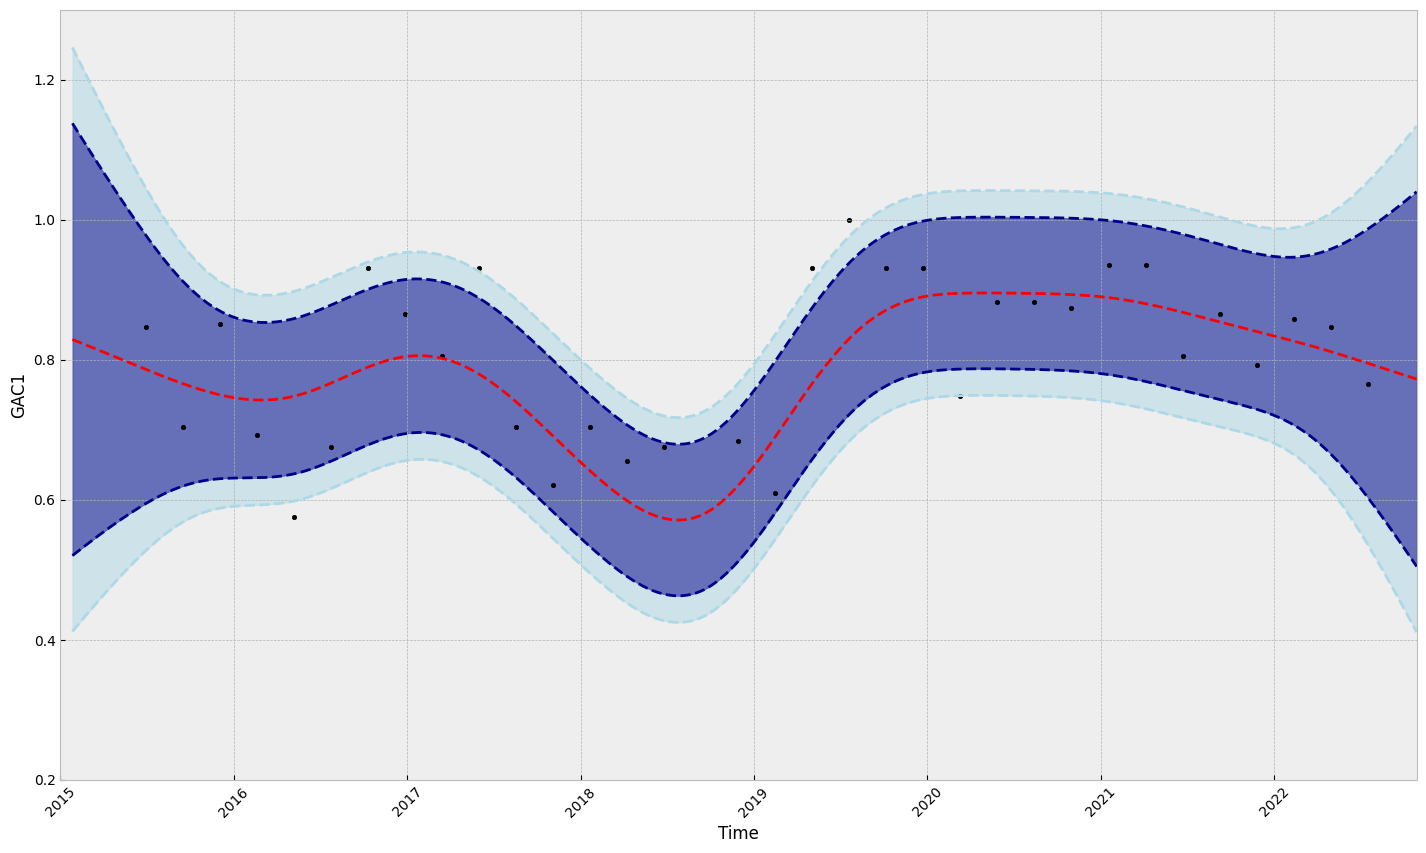

In [5]:
window_width = 205 #252
time_step = 78 #84
n_splines = int(550/time_step) + 20 #27
treshold = 4
plt.figure(figsize=(17.5, 10))
df_ufa, dict_words, widow_pairs = ufa_prediction(df_words, df_corpus, data_path, time_step, window_width, n_splines, treshold=4, n_start=30, n_end=20)
plt.xlabel("Time")
plt.ylabel("GAC1")
plt.ylim(0.2, 1.3)

## Ufa dataframe

In [6]:
# window pairs are vectors of (n_windows - 1, 2, n_words)
df_ufa['window_1'] = list(widow_pairs[:, 0, :])
df_ufa['window_2'] = list(widow_pairs[:, 1, :])

In [7]:
df_ufa['started'] = df_ufa.apply(lambda x: started_colocating(x, dict_words), axis=1)
df_ufa['stoped'] = df_ufa.apply(lambda x: stopped_colocating(x, dict_words), axis=1)
df_ufa['keep'] = df_ufa.apply(lambda x: keep_colocating(x, dict_words), axis=1)

df_ufa = df_ufa.drop(columns=['window_1', 'window_2'])
df_ufa.to_csv(f"files/results/{phrase}_plot_s_{time_step}_w_{window_width}.csv", index = False)

In [8]:
date_df = load_dates(data_path, window_width)

df_corpus = get_windows_columns(df_corpus, date_df)

df_corpus = format_corpus_df(df_corpus)

cols = ['text', 'id', 'date', 'source', 'collocations', 'eco_id']
data = df_corpus[cols]

data.to_csv(f"files/results/{phrase}_articles.csv", index=False)

/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_32759/3028352488.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus['first_window'] = None
/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_32759/3028352488.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus['second_window'] = None
/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_32759/3028352488.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

## Grid Search

In [ ]:
time_steps = np.arange(2, 3, 0.2)
widows_widths = []
for time_step in time_steps:
    widows_widths.append(np.linspace(1.5* time_step, 3*time_step, 5))
widows_widths = np.array(widows_widths)
time_steps *= 30
widows_widths *= 30
widows_widths = np.round(widows_widths, 0)
splines = [int(550/time_step + 20) for time_step in time_steps] 

In [ ]:
import os
import matplotlib.pyplot as plt

os.makedirs(data_path / "Plots", exist_ok=True)
for i, time_step in enumerate(time_steps):
    n_splines = splines[i]
    time_step = int(time_step)
    for j, window_width in enumerate(widows_widths[i]):
        window_width = int(window_width)
        plt.figure(figsize=(20, 10))
        ufa_prediction(df_words, df_corpus, data_path, time_step, window_width, n_splines=n_splines)
        plt.title(f"Time step:{time_step}, Window width: {window_width}")
        plt.savefig(data_path / "Plots" / f"s_{time_step}_w_{window_width}.png")
        plt.close()#

# Globalne Ocieplenie

s70, w 194; s 70, w 176; s 64, w 177; s 58, w 176; s 58, w 161

In [10]:
df_words, df_corpus, data_path = ufa_pipeline("global ociepl", "combo")

Real count: 2101
Raw count: 2102


47 windows created


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0, 0.5, 'GAC1')

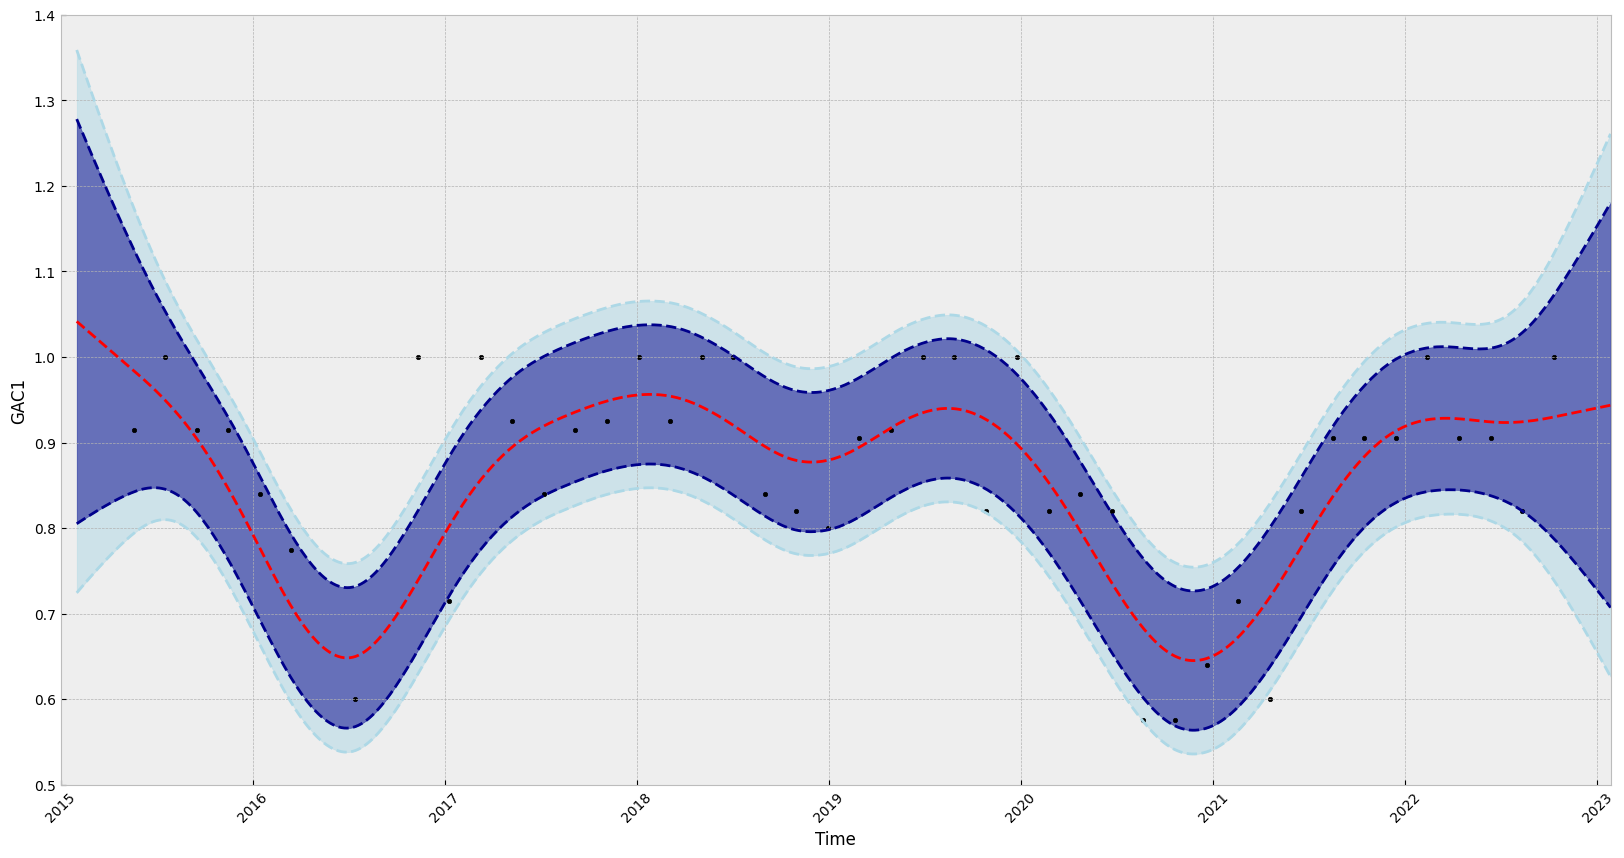

In [11]:
window_width = 158 #252
time_step = 60 #84
n_splines = int(550/time_step) + 20 #27
treshold = 4
plt.figure(figsize=(20, 10))
df_ufa, dict_words, widow_pairs = ufa_prediction(df_words, df_corpus, data_path, time_step, window_width, n_splines, treshold=4, n_start=20, n_end=20)
plt.ylim(0.5, 1.4)
plt.xlabel("Time")
plt.ylabel("GAC1")

In [12]:
df_ufa['window_1'] = list(widow_pairs[:, 0, :])
df_ufa['window_2'] = list(widow_pairs[:, 1, :])

In [13]:
df_ufa['started'] = df_ufa.apply(lambda x: started_colocating(x, dict_words), axis=1)
df_ufa['stoped'] = df_ufa.apply(lambda x: stopped_colocating(x, dict_words), axis=1)
df_ufa['keep'] = df_ufa.apply(lambda x: keep_colocating(x, dict_words), axis=1)

In [14]:
df_ufa = df_ufa.drop(columns=['window_1', 'window_2'])
phrase = "global ociepl"
df_ufa.to_csv(f"files/results/{phrase}_s_{time_step}_w_{window_width}.csv", index = False)

In [15]:
date_df = load_dates(data_path, window_width)

df_corpus = get_windows_columns(df_corpus, date_df)

df_corpus = format_corpus_df(df_corpus)

cols = ['text', 'id', 'date', 'source', 'collocations', 'eco_id']
data = df_corpus[cols]
data['eco_id'] = data['eco_id'].astype('Int32')

data.to_csv(f"files/results/{phrase}_articles.csv", index=False)

/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_32759/3028352488.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus['first_window'] = None
/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_32759/3028352488.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus['second_window'] = None
/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_32759/3028352488.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

## Grid search

In [ ]:
time_steps = np.arange(1.75, 2.25, 0.1)
widows_widths = []
for time_step in time_steps:
    widows_widths.append(np.linspace(2* time_step, 2.5*time_step, 5))
widows_widths = np.array(widows_widths)
time_steps *= 30
widows_widths *= 30
widows_widths = np.round(widows_widths, 0)
splines = [int(550/time_step + 20) for time_step in time_steps] 

In [ ]:
import os
import matplotlib.pyplot as plt

os.makedirs(data_path / "Plots", exist_ok=True)
for i, time_step in enumerate(time_steps):
    n_splines = splines[i]
    time_step = int(time_step)
    for j, window_width in enumerate(widows_widths[i]):
        window_width = int(window_width)
        plt.figure(figsize=(20, 10))
        ufa_prediction(df_words, df_corpus, data_path, time_step, window_width, n_splines=n_splines)
        plt.title(f"Time step:{time_step}, Window width: {window_width}")
        plt.savefig(data_path / "Plots" / f"s_{time_step}_w_{window_width}.png")
        plt.close()#

In [ ]:
window_width = 177
time_step = 64
n_splines = 32
df_ufa, dict_words, widow_pairs = ufa_prediction(df_words, df_corpus, data_path, time_step, window_width, n_splines)